# Imports

In [4]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

# Download necessary NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhpsk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Dataset

In [5]:
# Load dataset
df = pd.read_csv("../../1_DataPreprocessing/DataSets/CleanedDataset/combined_dataset.csv")  # Change to your actual filename

# Keep only the 'Description' column
descriptions = df["Description"].astype(str)

# Preprocessing

In [6]:
# Initialize preprocessing tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df["Cleaned_Description"] = descriptions.apply(preprocess_text)

df.to_csv("../../1_DataPreprocessing/DataSets/DBSCAN_Datasets/cleaned_base_dataset.csv", index=False)

###############################

# Load the cleaned dataset
df = pd.read_csv("../../1_DataPreprocessing/DataSets/DBSCAN_Datasets/cleaned_base_dataset.csv")

# normalize dataset

In [7]:
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df["Cleaned_Description"])

# normalize
scaler = StandardScaler()
tfidf_matrix_normalized = scaler.fit_transform(tfidf_matrix.toarray())

# apply dimensionality reduction

In [8]:
reduction_tech = 'pca'  # Toggle this to change dimensionality reduction technique

if reduction_tech.lower() == 'pca':
    reducer = PCA(n_components=2, random_state=42)
elif reduction_tech.lower() == 'tsne':
    reducer = TSNE(n_components=2, random_state=42)
else:
    reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.1)
    #reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)

reduced_embeddings = reducer.fit_transform(tfidf_matrix_normalized)

df["X"] = reduced_embeddings[:, 0]
df["Y"] = reduced_embeddings[:, 1]

# train, test, feature engineering

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv("../../1_DataPreprocessing/DataSets/DBSCAN_Datasets/train_data.csv", index=False)
val_df.to_csv("../../1_DataPreprocessing/DataSets/DBSCAN_Datasets/val_data.csv", index=False)

print("Feature engineering complete using TF-IDF + ", reduction_tech.upper())

Feature engineering complete using TF-IDF +  PCA


# use nearest neighbors to fit and plot

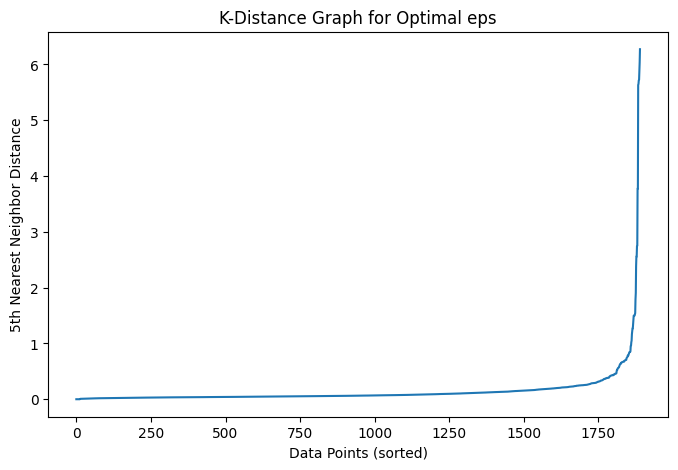

In [12]:
df = pd.read_csv("../../1_DataPreprocessing/DataSets/DBSCAN_Datasets/train_data.csv")
X = df[["X", "Y"]].values

nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("K-Distance Graph for Optimal eps")
plt.savefig("Charts/" + reduction_tech + ".png")
plt.show()

# loop over distances array to find the best hyperparams to use: eps with the best silhouette score

In [13]:
best_eps = None
best_score = -1
best_min_samples = 5  # Try reducing this to 3, 5, etc.

# Find the maximum values of the distances array
max_distance = np.max(distances)

# Iterate over different eps values
for eps in np.arange(0.1, max_distance, 0.01):  # Adjusted eps range
    dbscan = DBSCAN(eps=eps, min_samples=best_min_samples)
    labels = dbscan.fit_predict(X)
    
    # Skip if no valid clusters are found
    if len(set(labels) - {-1}) < 2:
        continue
    
    # Evaluate silhouette score
    score = silhouette_score(X, labels)
    if score > best_score:
        best_score = score
        best_eps = eps

# Fallback if no best eps is found
if best_eps is None:
    print("No valid eps found! Consider adjusting min_samples or checking data distribution.")
    best_eps = 0.5

print(f"Best eps: {best_eps}, Silhouette Score: {best_score:.3f}")

Best eps: 5.709999999999996, Silhouette Score: 0.912


# apply DBSCAN with best eps

In [14]:
# Apply DBSCAN with the best eps found
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df["Cluster"] = dbscan.fit_predict(X)
df.to_csv("../../1_DataPreprocessing/DataSets/DBSCAN_Datasets/dbscan_clustered.csv", index=False)

# final result (with spectral clustering)

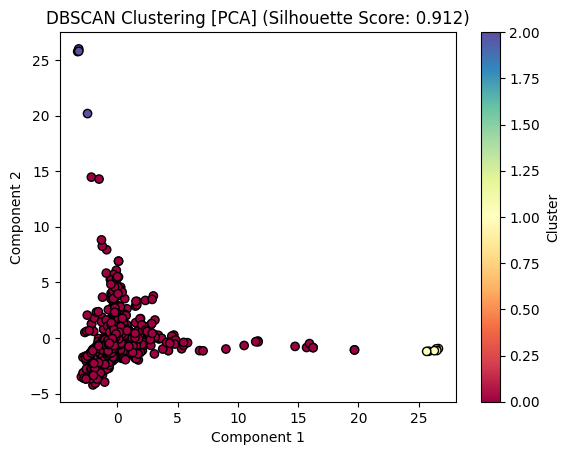

Clustering visualization saved as '4_Others/Charts/dbscan_clustering_visualization_pca.png'.


In [15]:
plt.scatter(df["X"], df["Y"], c=df["Cluster"], cmap="Spectral", marker="o", edgecolor="k")
plt.title(f"DBSCAN Clustering [{reduction_tech.upper()}] (Silhouette Score: {best_score:.3f})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.text(0.05, 0.95, f"eps = {best_eps}", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes, color='white')
plt.text(0.05, 0.90, f"min_samples = {best_min_samples}", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes, color='white')
plt.savefig("Charts/dbscan_clustering_visualization_" + reduction_tech + ".png")
plt.show()

print("Clustering visualization saved as '4_Others/Charts/dbscan_clustering_visualization_" + reduction_tech + ".png'.")

## score interpretation:
0.6 - 0.7: Fairly good clustering. The points are reasonably well-clustered, and the separation between clusters is decent.

0.7 - 1.0: Very good clustering. The points are well-grouped within clusters, and the clusters are clearly defined.

0.0 - 0.6: Clustering can be improved. The clusters might be overlapping or not very distinct.
Negative values: Points are likely misclassified or the clustering algorithm might not be appropriate.